In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

## Stochastic Setup

Let us specify the transition rates:
$$\begin{aligned}
\mathbb{P}(S \rightarrow E) &= \beta SI/N\\
\mathbb{P}(E \rightarrow I) &= \gamma E\\
\mathbb{P}(I \rightarrow R) &= \alpha I\\
\end{aligned}$$

These transition rates are then used in the CTMC forumlation.

In [2]:
def det_model(state, p):
    b, g, a = p
    s, e, i, r = state
    n = sum(state)
    return [
        -b*s*i/n,
        b*s*i/n - g*e,
        g*e - a*i,
        a*i
    ]

def transition(state, p):
    b, g, a = p
    s, e, i, r = state
    n = sum(state)
    update = copy.copy(state)
    # time to next event
    bins = np.array([b*s*i/n, g*e, a*i])
    sbins = np.linalg.norm(bins, ord=1)
    dt = np.random.exponential(1/sbins)
    # draw type of event and propagate
    bins /= sbins
    seed = np.random.uniform()
    x = np.digitize(seed, np.cumsum(bins))
    x = max(min(x, 2), 0)
    update[x] -= 1
    update[x+1] += 1
    return dt, update

In [3]:
y0 = [1000, 0, 1, 0]
p0 = [5, 0.1, 0.1]
    
def realise(y0, p):
    history = {'t': [], 'y':[]}
    t = 0
    y = y0

    T = 10000
    while t < T:
        history['t'].append(t)
        history['y'].append(y)
        if sum(y[1:-1]) == 0:
            break
        dt, y = transition(y, p0)
        t += dt
        
    return history

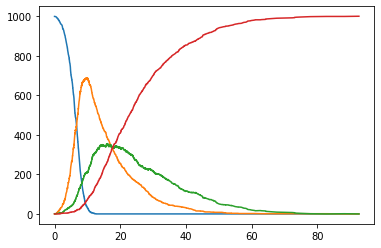

In [4]:
stoch = realise(y0, p0)
plt.plot(stoch['t'], stoch['y'])

In [5]:
realisations = [realise(y0, p0) for _ in range(100)]

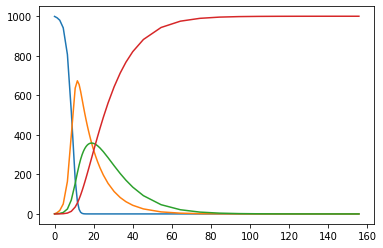

In [18]:
from scipy.integrate import solve_ivp

sol = solve_ivp(lambda t, y: det_model(y, p0), [0, max(r['t'][-1] for r in realisations)], y0, dense_output=True)
plt.plot(sol.t, sol.y.T)

/home/dwu402/.virtualenvs/scider/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


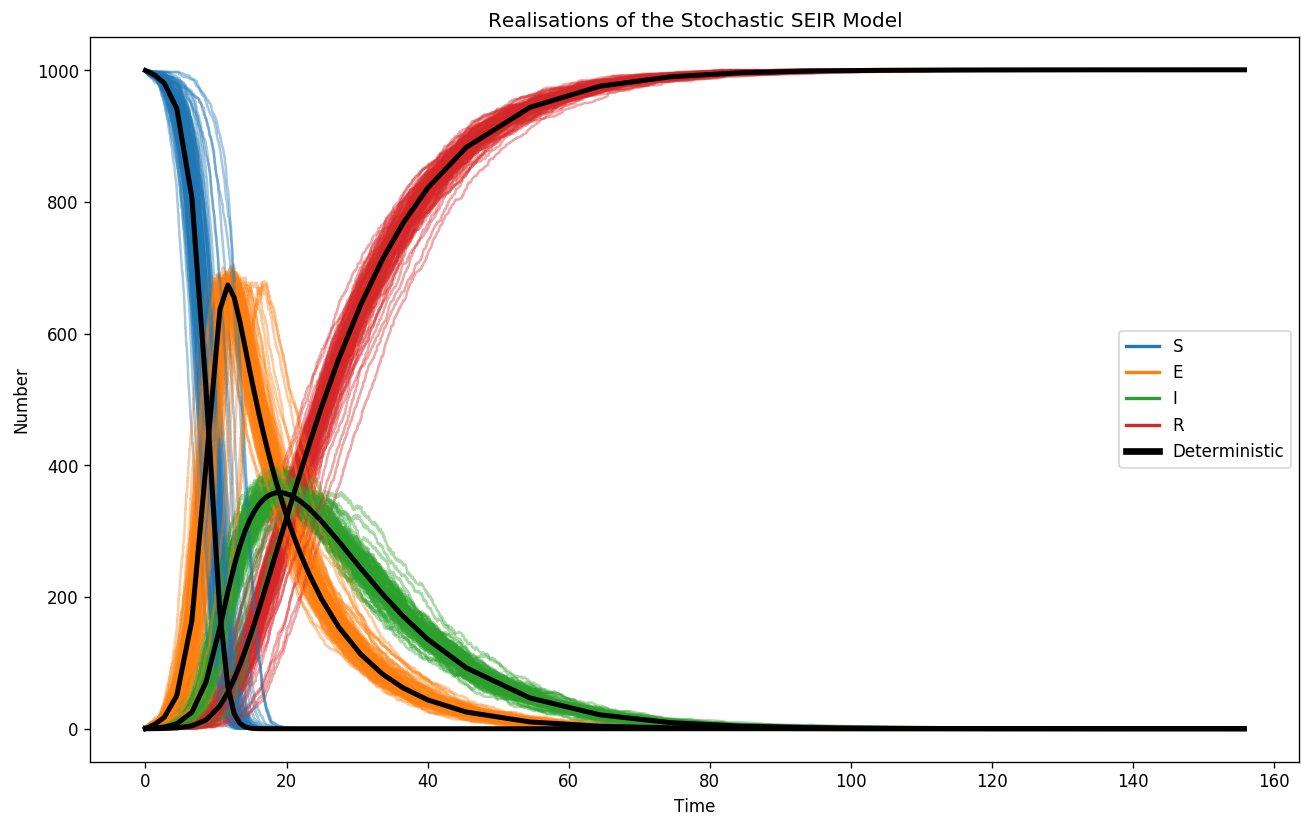

In [7]:
plt.figure(figsize=[13, 8], dpi=120)
dColours = plt.rcParams['axes.prop_cycle'].by_key()['color']
for realisation in realisations:
    plt.plot(realisation['t'], [k[0] for k in realisation['y']], dColours[0], alpha=0.4, label='S')
    plt.plot(realisation['t'], [k[1] for k in realisation['y']], dColours[1], alpha=0.4, label='E')
    plt.plot(realisation['t'], [k[2] for k in realisation['y']], dColours[2], alpha=0.4, label='I')
    plt.plot(realisation['t'], [k[3] for k in realisation['y']], dColours[3], alpha=0.4, label='R')
plt.plot(sol.t, sol.y.T, 'k', linewidth=3);

plt.title('Realisations of the Stochastic SEIR Model')
plt.xlabel('Time')
plt.ylabel('Number')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=dColours[0], lw=2),
                Line2D([0], [0], color=dColours[1], lw=2),
                Line2D([0], [0], color=dColours[2], lw=2),
                Line2D([0], [0], color=dColours[3], lw=2),
                Line2D([0], [0], color='k', lw=4)]
plt.legend(custom_lines, ['S', 'E', 'I', 'R', 'Deterministic'])

In [82]:
dydt = np.abs(np.array([det_model(state, p0) for state in sol.y.T]))

In [49]:
discr = []
for t in np.linspace(0, 100, 101):
    expect = sol.sol(t)[-1]
    tscore = []
    for realisation in realisations:
        tscore.append(np.interp(t, realisation['t'], [r[-1] for r in realisation['y']]))
    discr.append(np.mean(np.abs(np.array(tscore)-expect)))

Text(0, 0.5, '$\\mu_{|R_{stoch}-R_{determ}|}$')

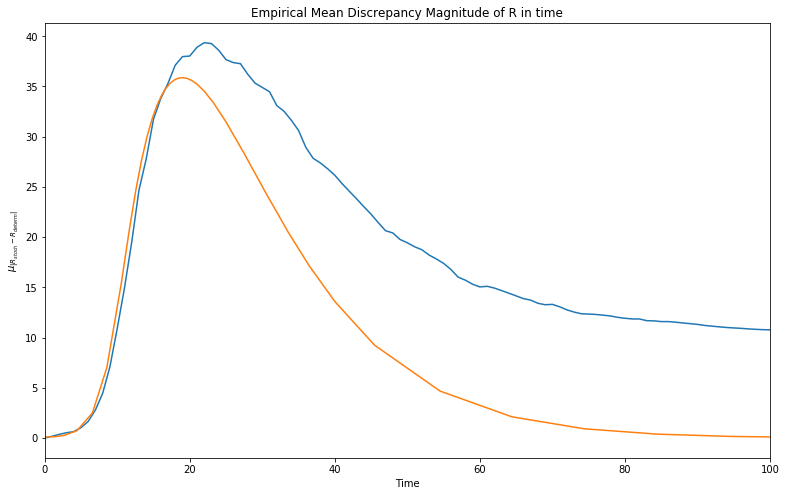

In [77]:
plt.figure(figsize=[13,8])
plt.plot(discr)
plt.plot(sol.t, dydt[:,-1])
plt.xlim([0,100])
plt.title('Empirical Mean Discrepancy Magnitude of R in time')
plt.xlabel('Time')
plt.ylabel(r'$\mu_{|R_{stoch}-R_{determ}|}$')

In [53]:
idiscr = []
for t in np.linspace(0, 100, 101):
    expect = sol.sol(t)[2]
    tscore = []
    for realisation in realisations:
        tscore.append(np.interp(t, realisation['t'], [r[2] for r in realisation['y']]))
    idiscr.append(np.mean(np.abs(np.array(tscore)-expect)))

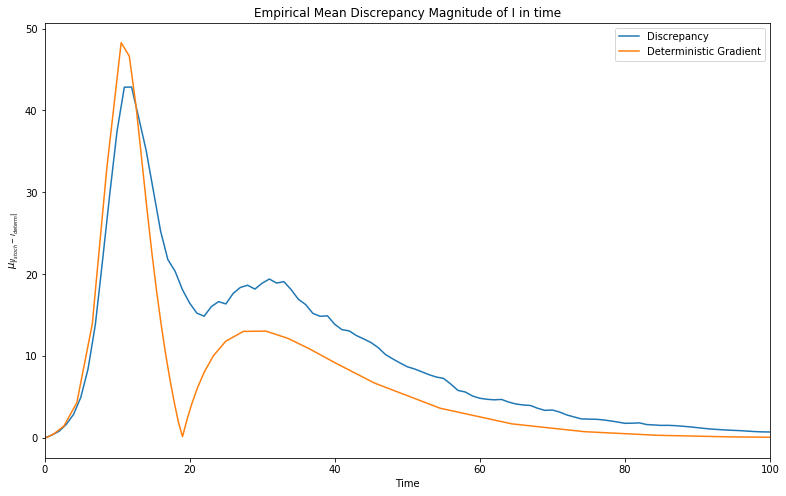

In [86]:
plt.figure(figsize=[13,8])
plt.plot(idiscr)
plt.plot(sol.t, dydt[:,2])
plt.xlim([0,100])
plt.title('Empirical Mean Discrepancy Magnitude of I in time')
plt.xlabel('Time')
plt.ylabel(r'$\mu_{|I_{stoch}-I_{determ}|}$')
plt.legend(['Discrepancy', 'Deterministic Gradient'])

In [63]:
ediscr = []
for t in np.linspace(0, 100, 101):
    expect = sol.sol(t)[1]
    tscore = []
    for realisation in realisations:
        tscore.append(np.interp(t, realisation['t'], [r[1] for r in realisation['y']]))
    ediscr.append(np.mean(np.abs(np.array(tscore)-expect)))

Text(0, 0.5, '$\\mu_{|E_{stoch}-E_{determ}|}$')

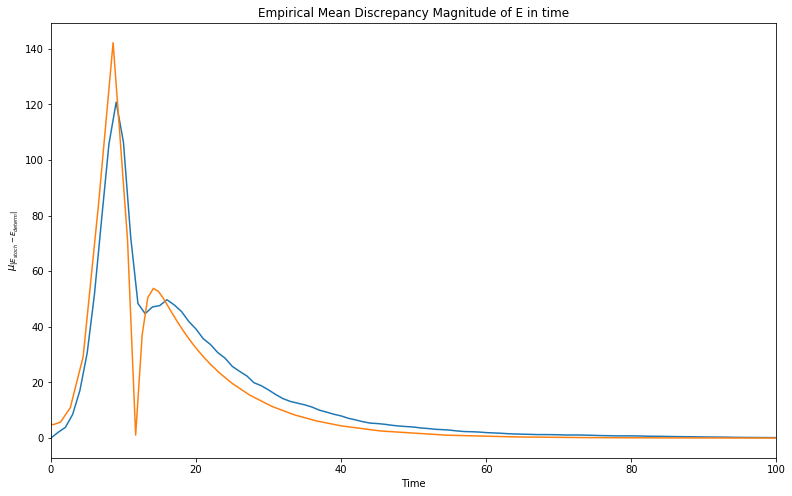

In [84]:
plt.figure(figsize=[13,8])
plt.plot(ediscr)
plt.plot(sol.t, dydt[:,1])
plt.xlim([0,100])
plt.title('Empirical Mean Discrepancy Magnitude of E in time')
plt.xlabel('Time')
plt.ylabel(r'$\mu_{|E_{stoch}-E_{determ}|}$')

In [65]:
sdiscr = []
for t in np.linspace(0, 100, 101):
    expect = sol.sol(t)[0]
    tscore = []
    for realisation in realisations:
        tscore.append(np.interp(t, realisation['t'], [r[0] for r in realisation['y']]))
    sdiscr.append(np.mean(np.abs(np.array(tscore)-expect)))

Text(0, 0.5, '$\\mu_{|S_{stoch}-S_{determ}|}$')

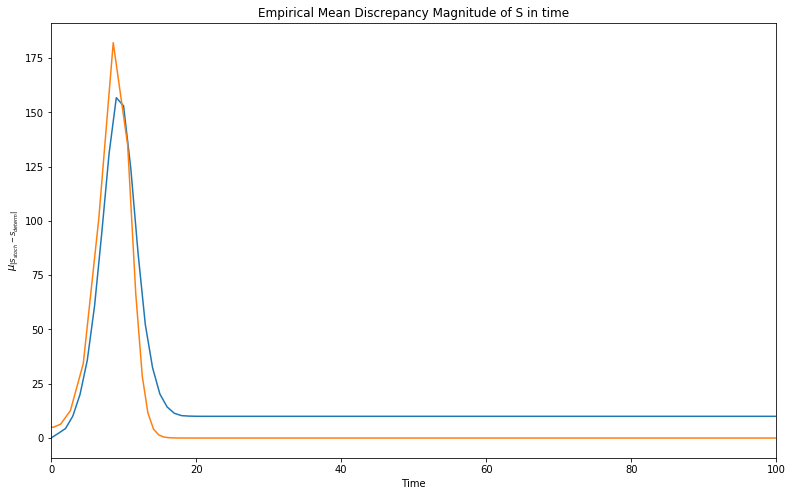

In [85]:
plt.figure(figsize=[13,8])
plt.plot(sdiscr)
plt.plot(sol.t, dydt[:,0])
plt.xlim([0,100])
plt.title('Empirical Mean Discrepancy Magnitude of S in time')
plt.xlabel('Time')
plt.ylabel(r'$\mu_{|S_{stoch}-S_{determ}|}$')